<a href="https://colab.research.google.com/github/amfaller/MassTrack-BlueBike/blob/main/MassTrack_PrivSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MassTrack: BlueBike
Author: Tony Faller (af3370)

## Description
The purpose of this Colab notebook is to serve as a space in which the MassTrack: BlueBike system will be implemented. This project builds on previous Private Systems coursework which examined CitiBike data.

CitiBike [releases public point-to-point data](https://citibikenyc.com/system-data) with fields such as start station, start time, stop station, and stop time. The previous work sought to answer the following questions:
* Given start station/time, can end station/time be determined?
* Is this information safe for public release?
  * Consider the case of harassment/stalking:
    * An adversary may see someone leave from a known station, note down the time, and later be able to determine exactly where that person went and what time they got there.
  * Consider the case of detecting patterns of favorite stations or co-riders:
    * An adversary may be able to track a rider over time.

BlueBike [also releases public point-to-point data](https://bluebikes.com/system-data) with the same fields as CitiBike. CitiBike and BlueBike are  the exact same thing -- and indeed, they are both owned by Bikeshare / Lyft -- but the former is implemented in New York City and the latter is implemented in Boston.

This project extends the prior research by examining BlueBike data to determine how widespread this problem may be. The terms-of-service of analyzing BlueBike data is available here: https://bluebikes.com/data-license-agreement


## Common Utilities

In [1]:
# This cell is for loading in data from Google Drive.
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/47744131/colaboratory-can-i-access-to-my-google-drive-folder-and-file
from google.colab import drive

drive.mount('/content/drive')
extractPath = '/content/data'

def extractZip(dataPath):
  with zipfile.ZipFile(dataPath, 'r') as zip_ref:
      zip_ref.extractall(extractPath)

Mounted at /content/drive


## Post-2023 Data
For the partition of After 2023, we examine the data for 2024.

In [2]:
# Per the Common Utilities, define functions to access the data.

import pandas as pd
import zipfile
import os

zipFileLocation = '/content/drive/My Drive/Classes/E6998/Colab Notebooks/Data/After2023/'

zipFiles = [
    "202401-bluebikes-tripdata.zip",
    "202402-bluebikes-tripdata.zip",
    "202403-bluebikes-tripdata.zip",
    "202404-bluebikes-tripdata.zip",
    "202405-bluebikes-tripdata.zip",
    "202406-bluebikes-tripdata.zip",
    "202407-bluebikes-tripdata.zip",
    "202408-bluebikes-tripdata.zip",
    "202409-bluebikes-tripdata.zip",
    "202410-bluebikes-tripdata.zip",
    "202411-bluebikes-tripdata.zip",
    "202412-bluebikes-tripdata.zip"
]

csvFiles = [
    "202401-bluebikes-tripdata.csv",
    "202402-bluebikes-tripdata.csv",
    "202403-bluebikes-tripdata.csv",
    "202404-bluebikes-tripdata.csv",
    "202405-bluebikes-tripdata.csv",
    "202406-bluebikes-tripdata.csv",
    "202407-bluebikes-tripdata.csv",
    "202408-bluebikes-tripdata.csv",
    "202409-bluebikes-tripdata.csv",
    "202410-bluebikes-tripdata.csv",
    "202411-bluebikes-tripdata.csv",
    "202412-bluebikes-tripdata.csv"

]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]

for file in zipFiles:
  extractZip(zipFileLocation + file)

def load2024Month(csvFile):
  filePath = extractPath + "/" + csvFile
  df =  pd.read_csv(filePath)

  # Convert `started_at` and `ended_at` to datetime format
  df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
  df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")

  return df

globalStartTimeFieldName = 'started_at'
globalEndTimeFieldName = 'ended_at'

globalStartStationFieldName = 'start_station_name'
globalEndStationFieldName = 'end_station_name'

## RQ1 (2024)
_Given a start station/time, can end station/time be uniquely determined?_

### Threat Model


Attacker Has:
* Start Station
* Start Time within N minutes

Attacker can Gain:
* End Station
* Precise Start Time
* Precise End Time

Parameter(s):
* `N` - Start time Granularity

Efficacy Metric:
* (Percentage of unique rows for each month in 2024) per granularity

In [3]:
def computeUniqueness(df, roundedFieldName):
  # Identify duplicates based on start time and station
  # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
  duplicateIdentifier = df.duplicated(subset=[globalStartStationFieldName, roundedFieldName], keep=False)

  # duplicateIdentifier is a simple key/value set of the same length as df.
  #
  # The key is the index of df, and the value is TRUE if that particular df row is
  # duplicated (i.e. seen somewhere else within df at a different index).
  #
  # If all rows are unique, the entire duplicateIdentifier array will be FALSE.

  # Compute percentage of unique rows
  return (1 - duplicateIdentifier.mean()) * 100

# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
def computeUniquenessPerGranularity(df, granularity='ns'):
  df = df.copy()

  df['rounded_start_time'] = df[globalStartTimeFieldName].dt.floor(granularity)
  return computeUniqueness(df, 'rounded_start_time')


def RQ1(df, monthIdx):
  granularities = ['ns', '1min', '5min', '10min', '15min', '30min', '60min']
  results = []

  for gran in granularities:
    percentUnique = computeUniquenessPerGranularity(df, gran)
    results.append({"Month": months[monthIdx], "Granularity": gran, "Percent Unique": percentUnique})

  return results

In [4]:
allResults = []

for monthIdx, csvFile in enumerate(csvFiles):
  df = load2024Month(csvFile)
  allResults.extend(RQ1(df, monthIdx))

df_results = pd.DataFrame(allResults)

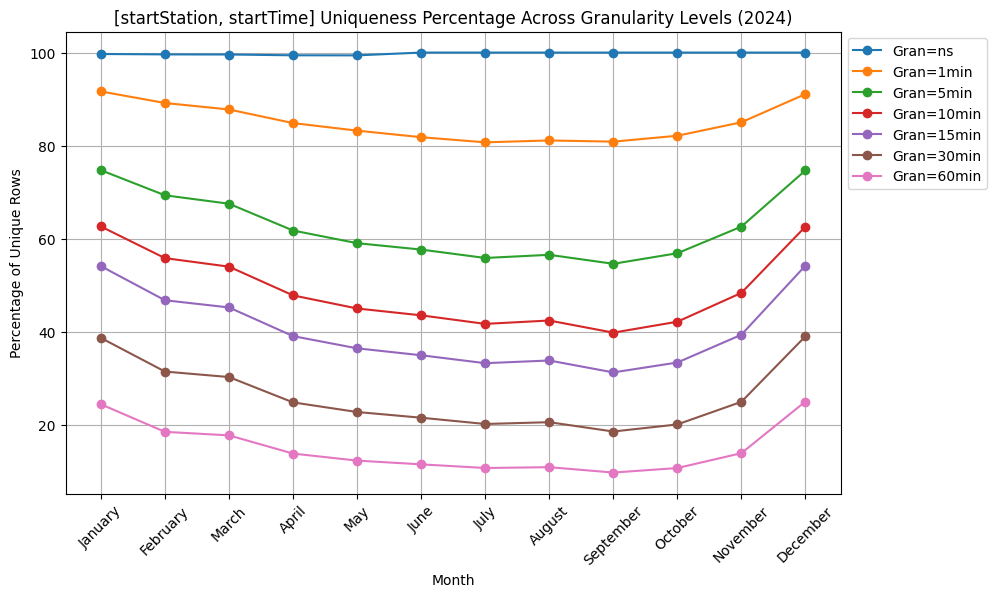

In [5]:
# Plotting
plt.figure(figsize=(10, 6))
for gran in df_results["Granularity"].unique():
    subset = df_results[df_results["Granularity"] == gran]
    plt.plot(subset["Month"], subset["Percent Unique"], marker='o', label=f'Gran={gran}')

plt.xlabel("Month")
plt.ylabel("Percentage of Unique Rows")
plt.title("[startStation, startTime] Uniqueness Percentage Across Granularity Levels (2024)")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### Time of Day
Are there fewer uniquely-identifiable rides at a particular time of day? Partition rows based on start time, per the following:

* Morning: 5a - 12p
* Afternoon: 12p - 5p
* Evening: 5p - 9p
* Night: 9p - 5a

In [6]:
def partitionOnTime(time):
  hour = time.hour

  if 5 <= hour < 12:
    return 'Morning (5a-12p)'
  elif 12 <= hour < 17:
    return 'Afternoon (12p-5p)'
  elif 17 < hour <= 21:
    return 'Evening (5p-9p)'
  else:
    return 'Night (9p-5a)'

def computeUniquenessPerGranularityAndTimePeriod(df, granularities):
  df = df.copy()

  # https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html
  df['time_period'] = df[globalStartTimeFieldName].dt.time.apply(partitionOnTime);

  # Dictionary to store results
  res = {}

  # Split original df by time period, creating independent per-period datasets
  uniqueTimePeriods = df['time_period'].unique()
  for period in uniqueTimePeriods:
    subset = df[df['time_period'] == period].copy()

    # Compute uniqueness for each granularity
    periodRes = {}
    for gran in granularities:
      percentUnique = computeUniquenessPerGranularity(subset, gran)
      periodRes[gran] = percentUnique

    # Store off the results for this time period
    res[period] = periodRes

  return res

def RQ1_TimeOfDay(df, monthIdx) :
  granularities = ['ns', '1min', '5min', '10min', '15min', '30min', '60min']

  out = computeUniquenessPerGranularityAndTimePeriod(df, granularities)

  results = []
  for time_period, granularities_dict in out.items():
    for granularity, percent_unique in granularities_dict.items():
      results.append({
        "Month": months[monthIdx],
        "Time Period": time_period,
        "Granularity": granularity,
        "Percent Unique": percent_unique
      })

  return results

In [7]:
allResults = []

for monthIdx, csvFile in enumerate(csvFiles):
  df = load2024Month(csvFile)
  allResults.extend(RQ1_TimeOfDay(df, monthIdx))

df_results = pd.DataFrame(allResults)

<ipython-input-8-f1748f6e923b>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg = df_results.groupby(["Month", "Granularity", "Time Period"])["Percent Unique"].mean().reset_index()


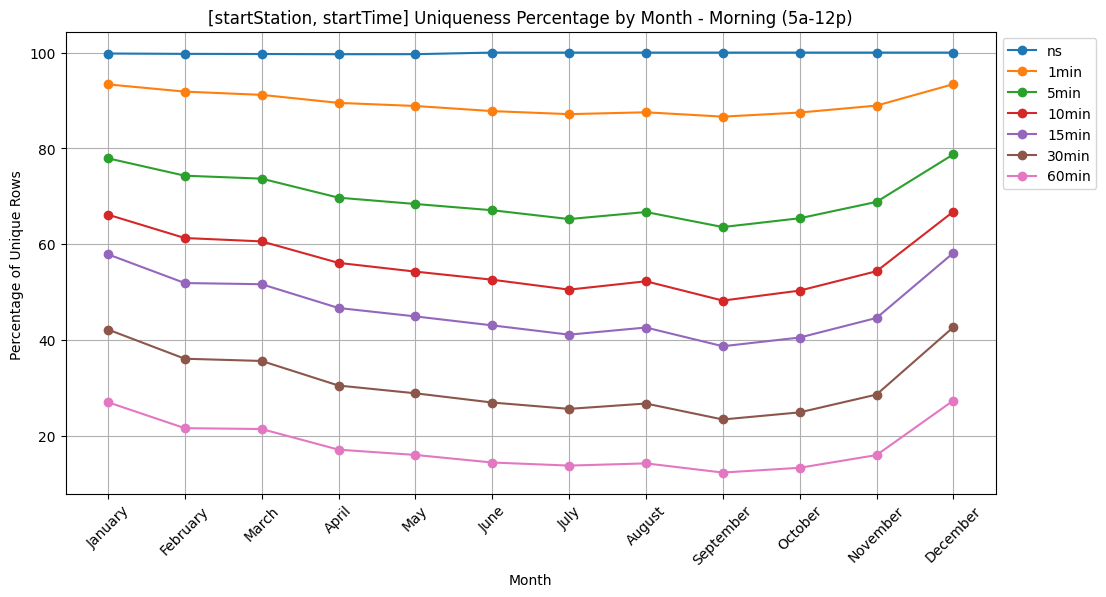

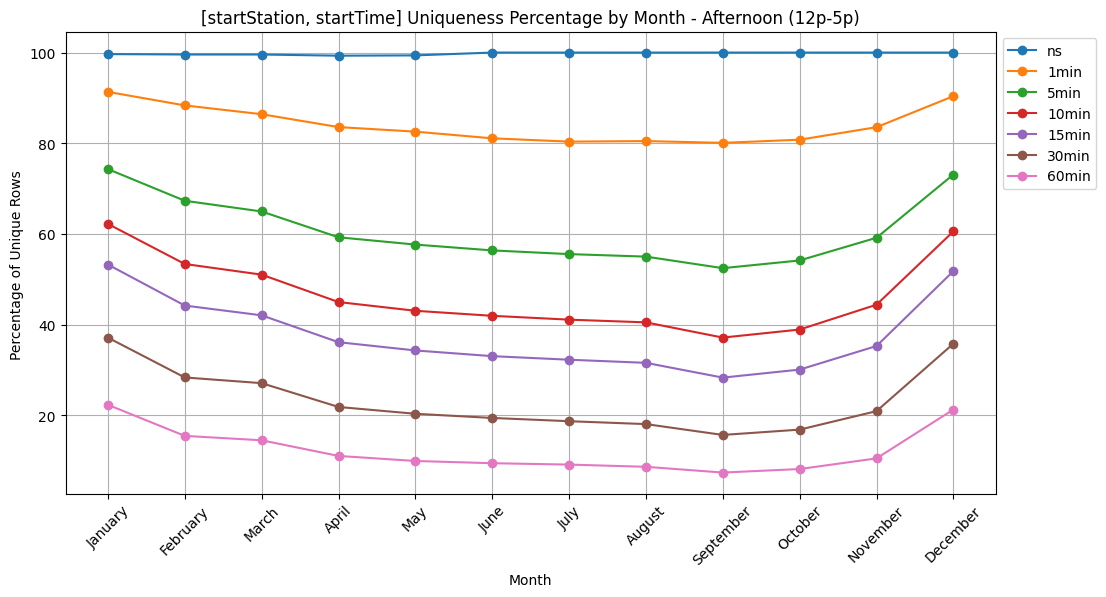

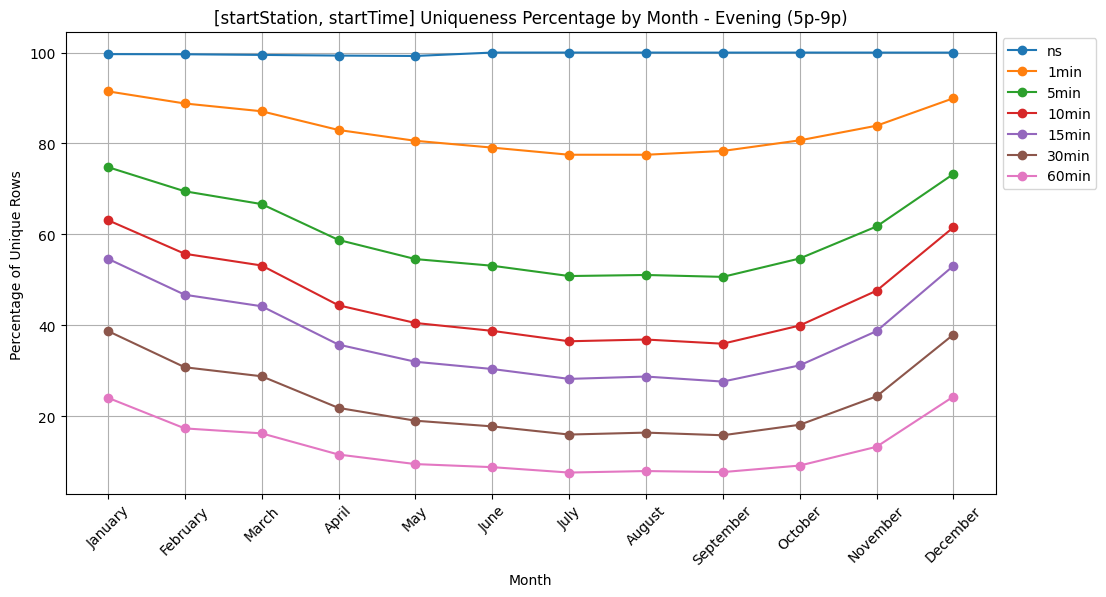

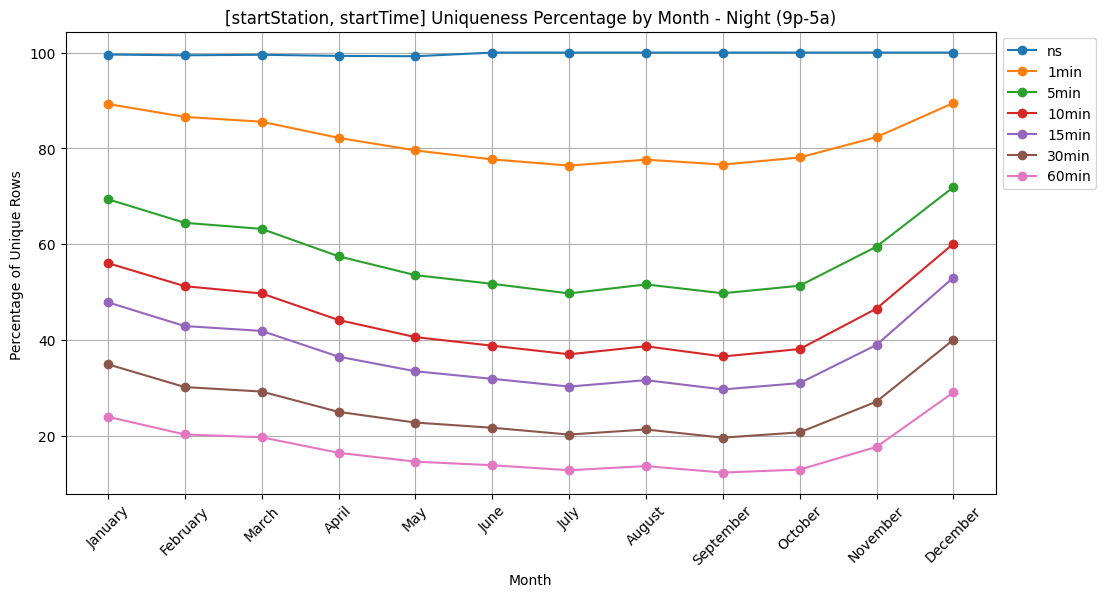

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Define time periods and granularities
time_periods = ["Morning (5a-12p)", "Afternoon (12p-5p)", "Evening (5p-9p)", "Night (9p-5a)"]
granularity_order = ['ns', '1min', '5min', '10min', '15min', '30min', '60min']

# Ensure Month is categorical but retains string labels
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
df_results["Month"] = pd.Categorical(df_results["Month"], categories=month_order, ordered=True)

# Convert Granularity to categorical for correct ordering
df_results["Granularity"] = pd.Categorical(df_results["Granularity"], categories=granularity_order, ordered=True)

# Compute monthly averages
monthly_avg = df_results.groupby(["Month", "Granularity", "Time Period"])["Percent Unique"].mean().reset_index()

# Generate separate plots for each time of day
for time_period in time_periods:
    plt.figure(figsize=(12, 6))

    for granularity in granularity_order:
        # Filter the data FIRST before trying to sort it
        gran_subset = monthly_avg[(monthly_avg["Time Period"] == time_period) & (monthly_avg["Granularity"] == granularity)]

        # Ensure subset has data before plotting
        if gran_subset.empty:
            print(f"Skipping {granularity} for {time_period}: No data found.")
            continue

        # Sort using month order while keeping labels intact
        gran_subset = gran_subset.sort_values("Month", key=lambda x: x.map({m: i for i, m in enumerate(month_order)}))

        # Now, plot the data
        plt.plot(gran_subset["Month"], gran_subset["Percent Unique"], marker="o", label=granularity)

    plt.xlabel("Month")
    plt.ylabel("Percentage of Unique Rows ")
    plt.title(f"[startStation, startTime] Uniqueness Percentage by Month - {time_period}")
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)

    plt.show()



### Takeaways

These results indicate that at precise timestamps, nearly every ride is unique -- meaning that if an adversary knows the exact start station and time, they can always determine the end station and time.

However, as granularity increases, uniqueness drops significantly:

* At 1-minute granularity, uniqueness is between 80-95%
* At 5 minutes, it is ~55-75%
* At 10 minutes, it is 40-60%
* At maximum courseness (60 minutes) it is nonzero at 10-20%

This suggests that rounding this dataset's timestamps would increase its privacy, though it is never completely secure.

Additionally, note that rides are more unique in the Winter months and less unique in the Summer months. This is likely due to fewer people riding bikes in the cold Winter as opposed to the warm Summer.

##### Time of Day
Time of day did not appear to play a significant role in uniqueness.

## RQ2
_Does Co-Riding Increase Privacy Vulnerability?_

#### Threat Model

Attacker Has:
* Start Station
* End Station
* Knows a group of R riders rode together

Attacker can Gain:
* Start Time of rides
* Stop Time of rides


Parameter(s):
* `gran` - Time Granularity
  * How close each ride started/stopped within each other
* `groupSize` - Group Size
  * 2 riders, 3 riders, etc

Efficacy Metric:
* (Percentage of rows with exactly (`groupSize`-1) matches per month in 2024) per granularity

A match exists if, for any two records:
* The start stations are the same
* The end stations are the same
* The start times are within `gran` of each other
* The end times are within `gran` of each other

In [9]:
import pandas as pd
import numpy as np

def calculate_co_riding(df, granularity, groupSize, monthIdx):
    df["rounded_start_time"] = df[globalStartTimeFieldName].dt.floor(granularity)
    df["rounded_end_time"] = df[globalEndTimeFieldName].dt.floor(granularity)

    # Group rides by (startStation, endStation, rounded timestamps)
    grouped = df.groupby([globalStartStationFieldName, globalEndStationFieldName, "rounded_start_time", "rounded_end_time"])

    match_counts = []  # Track rides with exactly (groupSize - 1) matches

    for _, trips in grouped:
        trip_count = len(trips)

        if trip_count == groupSize:  # Looking for exact matches
            match_counts.append(trip_count)

    # Calculate percentage of unique rows
    percent_unique = (len(match_counts) / len(df)) * 100 if len(df) > 0 else 0

     # Return results in a structured DataFrame
    return pd.DataFrame({
        "Month": [months[monthIdx]],
        "Granularity": [granularity],
        "Group Size": [groupSize],
        "Percent Unique": [percent_unique]
    })


In [10]:
def RQ2(group_size = 2):
  allResults = []
  granularities = ["1min", "2min", "3min", "4min", "5min"]

  for monthIdx, csvFile in enumerate(csvFiles):
    df = load2024Month(csvFile)
    for granularity in granularities:
      result_df = calculate_co_riding(df, granularity, group_size, monthIdx)
      allResults.append(result_df)

  # Concatenate all results into a single DataFrame
  df_results = pd.concat(allResults, ignore_index=True)

  # Ensure Month is categorical for correct ordering
  df_results["Month"] = pd.Categorical(df_results["Month"], categories=months, ordered=True)

  plt.figure(figsize=(12, 6))

  for granularity in granularities:
      gran_subset = df_results[df_results["Granularity"] == granularity]
      plt.plot(gran_subset["Month"], gran_subset["Percent Unique"], marker="o", label=granularity)

  plt.xlabel("Month")
  plt.ylabel("Average Percentage of Unique Rides")
  plt.title(f"Uniqueness Percentage Across Months (Group Size = {group_size})")
  plt.xticks(rotation=45)
  plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
  plt.grid(True)

  plt.show()

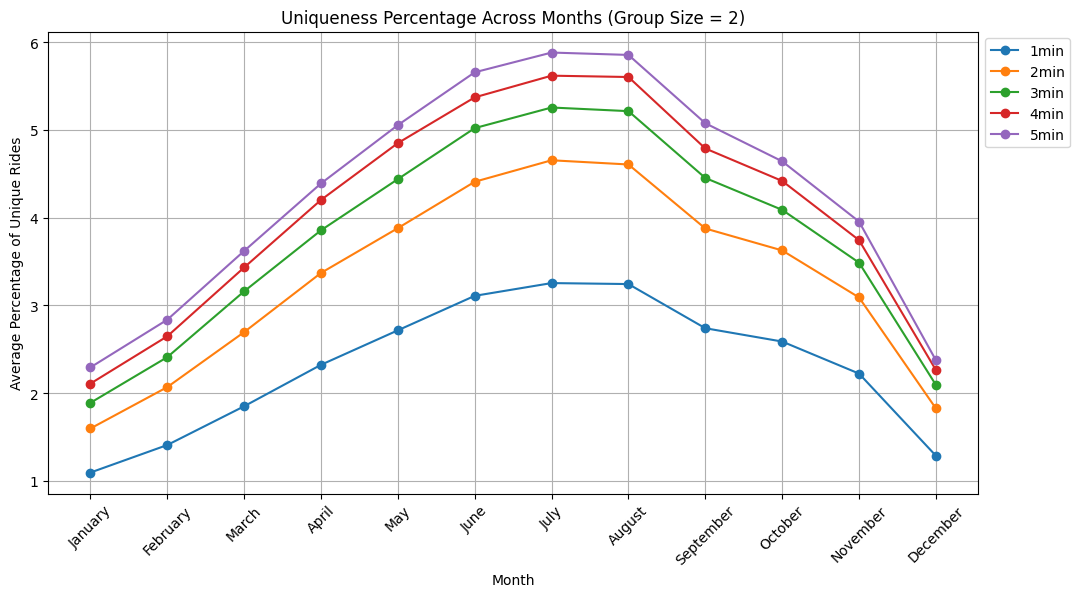

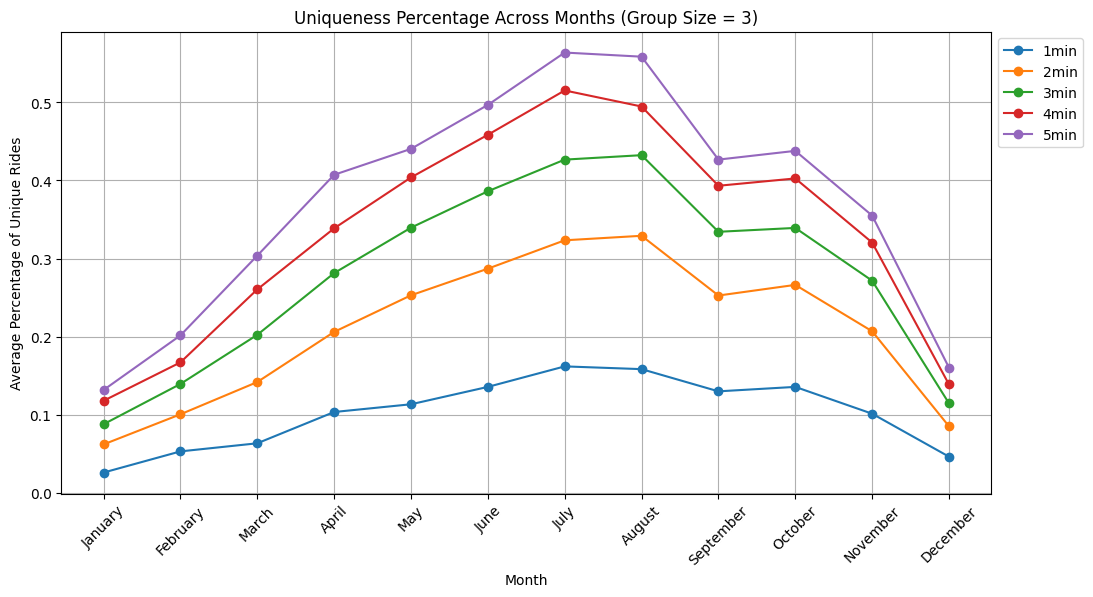

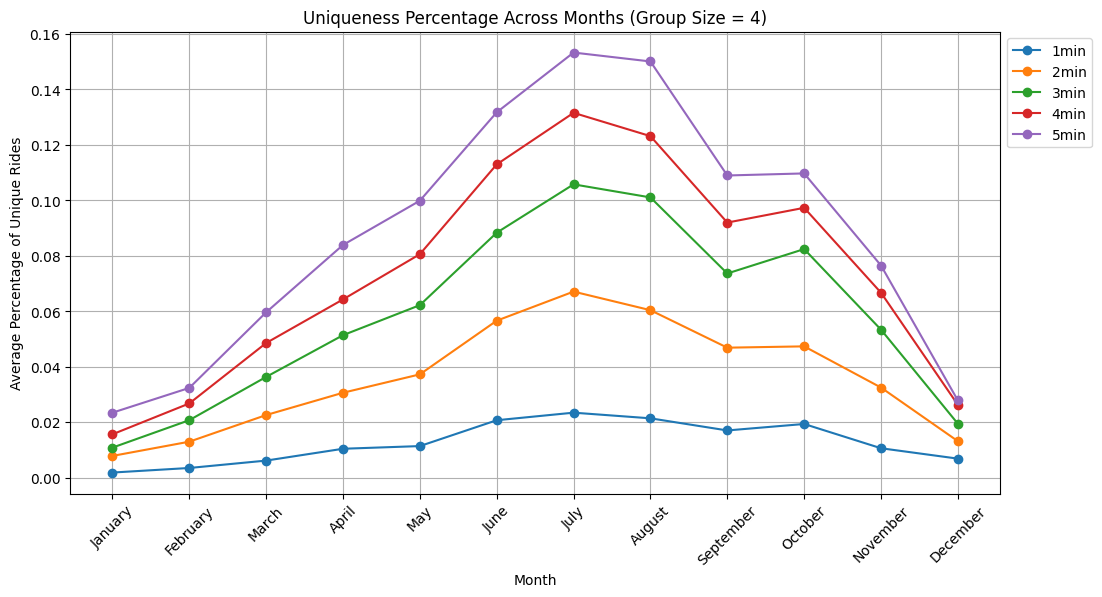

In [11]:
groupSizes = [2, 3, 4]
for groupSize in groupSizes:
  RQ2(groupSize)

### Takeaways
The key takeaway here is that a courser granularity makes it easier to identify matching rides. Across varying group sizes, the percentage of unique rides is consistently higher as the granularity increases.

Another takeaway is that as group size increases, the likeliness of uniquely identifying matching rides decreases sharply, from ~6% at maximum for a group of 2 to nearly 0% with a group of 5.

If an adversary knows with 100% certainty that a group ride occurs, that adversary's search space is dramatically reduced (i.e. they only need to scan 6% of the dataset, as opposed to 94% for solo rides).

## May 2020 - March 2023 Data

For this partition, we examine 2022.

In [12]:
# Per the Common Utilities, define functions to access the data.

import pandas as pd
import zipfile
import os

zipFileLocation = '/content/drive/My Drive/Classes/E6998/Colab Notebooks/Data/May2020ToMarch2023/'

zipFiles = [
    "202201-bluebikes-tripdata.zip",
    "202202-bluebikes-tripdata.zip",
    "202203-bluebikes-tripdata.zip",
    "202204-bluebikes-tripdata.zip",
    "202205-bluebikes-tripdata.zip",
    "202206-bluebikes-tripdata.zip",
    "202207-bluebikes-tripdata.zip",
    "202208-bluebikes-tripdata.zip",
    "202209-bluebikes-tripdata.zip",
    "202210-bluebikes-tripdata.zip",
    "202211-bluebikes-tripdata.zip",
    "202212-bluebikes-tripdata.zip"
]

csvFiles = [
    "202201-bluebikes-tripdata.csv",
    "202202-bluebikes-tripdata.csv",
    "202203-bluebikes-tripdata.csv",
    "202204-bluebikes-tripdata.csv",
    "202205-bluebikes-tripdata.csv",
    "202206-bluebikes-tripdata.csv",
    "202207-bluebikes-tripdata.csv",
    "202208-bluebikes-tripdata.csv",
    "202209-bluebikes-tripdata.csv",
    "202210-bluebikes-tripdata.csv",
    "202211-bluebikes-tripdata.csv",
    "202212-bluebikes-tripdata.csv"

]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]

for file in zipFiles:
  extractZip(zipFileLocation + file)

def load2022Month(csvFile):
  filePath = extractPath + "/" + csvFile
  df =  pd.read_csv(filePath)

  # Convert `starttime` and `stoptime` to datetime format
  df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
  df["stoptime"] = pd.to_datetime(df["stoptime"], errors="coerce")

  return df

globalStartTimeFieldName = 'starttime'
globalEndTimeFieldName = 'stoptime'

globalStartStationFieldName = 'start station name'
globalEndStationFieldName = 'end station name'

## RQ3
_Is the combination of (Postal Code, User Type, Start Station) a pseudo-identifier?_

Attacker has:
* Postal Code
* User Type
* Start Station

Attacker gains:
* End Station
* Start Time
* End Time

Parameter(s): None

Efficacy Metric: Percentage of unique rows for each month in 2024


In [13]:
import pandas as pd

def computeUniqueness(df):
    # Identify duplicates based on postal code, user type, and start station name
    duplicateIdentifier = df.duplicated(subset=['postal code', 'usertype', globalStartStationFieldName], keep=False)

    # Compute percentage of unique rows
    return (1 - duplicateIdentifier.mean()) * 100

def RQ3(df, monthIdx, N):
    percentUnique = computeUniqueness(df)

    # Collect unique pseudo-identifiers
    groups = df.groupby(['usertype', 'postal code', 'start station name']).size().reset_index(name='count')
    uniqueGroups = groups[groups['count'] == 1]

    mostPopularGroups = groups.sort_values(by='count', ascending=False).head(N)

    return [{"Month": months[monthIdx], "Percent Unique": percentUnique, "Combinations": uniqueGroups.sample(N), "Popular": mostPopularGroups.head(N)}]


In [14]:
allResults = []
numCombosToOutput = 10

for monthIdx, csvFile in enumerate(csvFiles):
  df = load2022Month(csvFile)
  allResults.extend(RQ3(df, monthIdx, numCombosToOutput))

df_results = pd.DataFrame(allResults)

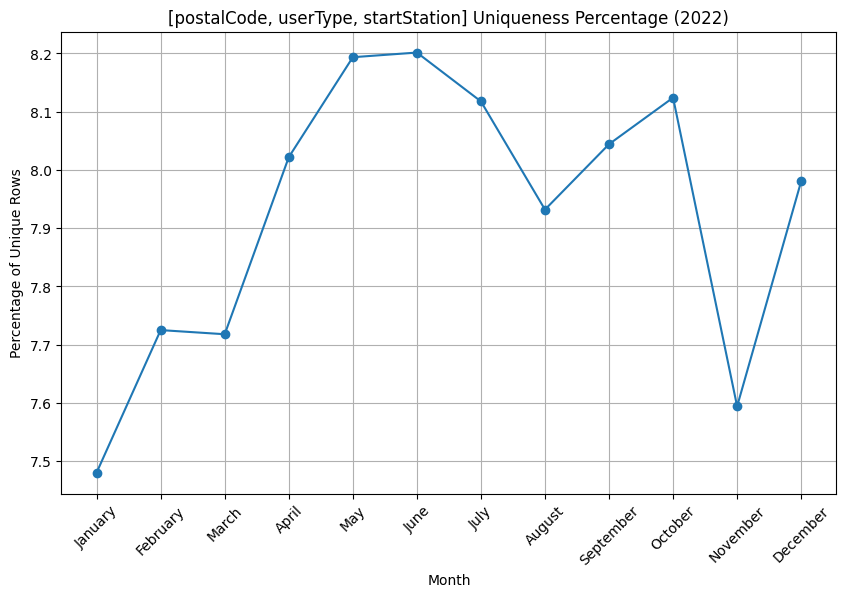

In [15]:
# Plot
#
plt.figure(figsize=(10, 6))
plt.plot(df_results["Month"], df_results["Percent Unique"], marker='o')

plt.xlabel("Month")
plt.ylabel("Percentage of Unique Rows")
plt.title("[postalCode, userType, startStation] Uniqueness Percentage (2022)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [16]:
# Print out some of the unique combinations for each month
#
print(f"Random {numCombosToOutput} Unique Combinations (2022)")
print("-"*50)

for index, row in df_results.iterrows():
    print(f"{row['Month']}:")

    # Iterate over the DataFrame stored in the 'Combinations' column
    for _, combo_row in row['Combinations'].iterrows():
        print(f" | {combo_row['usertype']}, {combo_row['postal code']}, {combo_row['start station name']}")
    print(" ")

Random 10 Unique Combinations (2022)
--------------------------------------------------
January:
 | Subscriber, 65781, MIT Stata Center at Vassar St / Main St
 | Customer, 02150, Seaport Blvd at Sleeper St
 | Subscriber, 02478, Cambridge St at Joy St
 | Subscriber, 15213, South Station - 700 Atlantic Ave
 | Customer, 01821, Ruggles T Stop - Columbus Ave at Melnea Cass Blvd
 | Subscriber, 02110, Berkshire Street at Cambridge Street
 | Subscriber, 02143, Prudential Center - 101 Huntington Ave
 | Customer, 02135, Perry Park
 | Subscriber, 92129, Lower Cambridgeport at Magazine St / Riverside Rd
 | Customer, 02769, Seaport Square - Seaport Blvd at Northern Ave
 
February:
 | Subscriber, 02124, Central Sq Post Office / Cambridge City Hall at Mass Ave / Pleasant St
 | Customer, 07078, Tremont St at Northampton St
 | Customer, 11201, Harvard Square at Brattle St / Eliot St
 | Subscriber, 30342, 645 Summer St
 | Customer, 01030, Packard's Corner - Commonwealth Ave at Brighton Ave
 | Customer, 

In [17]:
# Print out some of the unique combinations for each month
#
print(f"Top {numCombosToOutput} Most Common Combinations (2022)")
print("-"*50)

for index, row in df_results.iterrows():
    print(f"{row['Month']}:")

    # Iterate over the DataFrame stored in the 'Combinations' column
    for _, combo_row in row['Popular'].iterrows():
        print(f" | {combo_row['count']} : {combo_row['usertype']}, {combo_row['postal code']}, {combo_row['start station name']}")
    print(" ")

Top 10 Most Common Combinations (2022)
--------------------------------------------------
January:
 | 1492 : Subscriber, 02139, MIT at Mass Ave / Amherst St
 | 1351 : Subscriber, 02139, MIT Pacific St at Purrington St
 | 1100 : Subscriber, 02139, Central Square at Mass Ave / Essex St
 | 941 : Subscriber, 02139, MIT Vassar St
 | 651 : Subscriber, 02139, MIT Stata Center at Vassar St / Main St
 | 538 : Subscriber, 02139, Lafayette Square at Mass Ave / Main St / Columbia St
 | 494 : Subscriber, 02139, Lower Cambridgeport at Magazine St / Riverside Rd
 | 467 : Subscriber, 02139, Mass Ave at Albany St
 | 457 : Subscriber, 02139, 359 Broadway - Broadway at Fayette Street
 | 393 : Subscriber, 02139, MIT Carleton St at Amherst St
 
February:
 | 1936 : Subscriber, 02139, MIT at Mass Ave / Amherst St
 | 1776 : Subscriber, 02139, MIT Pacific St at Purrington St
 | 1363 : Subscriber, 02139, MIT Vassar St
 | 1182 : Subscriber, 02139, Central Square at Mass Ave / Essex St
 | 1069 : Subscriber, 02139

### Takeaways
Across 2022, the uniqueness percentage based on the combination of _(postalCode, userType, startStation)_ remained around 7.5-8%. This implies that this combination is not a strong pseudo-identifier.

Speculation: This could be caused by many users entering the same Boston-local postalCode, which would greatly ambiguate records.

## RQ4
_Is the combination of (Postal Code, User Type, Start Time) a pseudo-identifier?_

Attacker has:
* Postal Code
* User Type
* Start Time (within N minutes)

Attacker gains:
* Start Station
* End Station
* End Time

Parameter(s): N - Start time granularity

Efficacy Metric: (Percentage of unique rows for each month in 2024) per granularity


In [18]:
import pandas as pd

def computeUniqueness(df, roundedFieldName):
    # Identify duplicates based on postal code, user type, and rounded start time
    duplicateIdentifier = df.duplicated(subset=['postal code', 'usertype', roundedFieldName], keep=False)

    # Compute percentage of unique rows
    return (1 - duplicateIdentifier.mean()) * 100

def computeUniquenessPerGranularity(df, granularity='ns'):
    df = df.copy()
    df['rounded_start_time'] = df[globalStartTimeFieldName].dt.floor(granularity)
    return computeUniqueness(df, 'rounded_start_time')

def RQ4(df, monthIdx):
    granularities = ['ns', '1min', '5min', '10min', '15min', '30min', '60min']
    results = []

    for gran in granularities:
        percentUnique = computeUniquenessPerGranularity(df, gran)
        results.append({"Month": months[monthIdx], "Granularity": gran, "Percent Unique": percentUnique})

    return results


In [19]:
allResults = []

for monthIdx, csvFile in enumerate(csvFiles):
  df = load2022Month(csvFile)
  allResults.extend(RQ4(df, monthIdx))

df_results = pd.DataFrame(allResults)

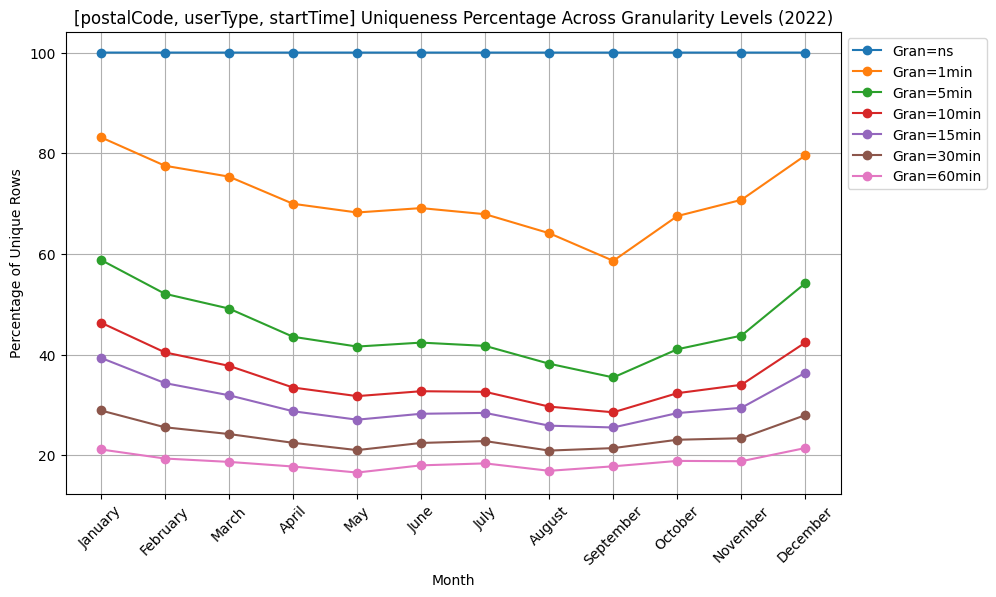

In [20]:
# Plot
#
plt.figure(figsize=(10, 6))
for gran in df_results["Granularity"].unique():
    subset = df_results[df_results["Granularity"] == gran]
    plt.plot(subset["Month"], subset["Percent Unique"], marker='o', label=f'Gran={gran}')

plt.xlabel("Month")
plt.ylabel("Percentage of Unique Rows")
plt.title("[postalCode, userType, startTime] Uniqueness Percentage Across Granularity Levels (2022)")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### Takeaways
At precise timestamps, every ride is uniquely identifiable. However, as soon as granularity increases, uniqueness drops greatly; this implies that these fields strongly constitute a pseudo-identifier when timestamp granularity is fine.

There is also a notable drop in September. This could be attributed to multiple possible things:
* Generally, ride volume is higher due to influx of students
* Perhaps more non-local students use local zip codes, ambiguating records

## RQ1 (2022)
The key "attack ingredients" of start/stop station/time persist throughout each partition. We can apply the same analysis from RQ1 on this partition to demonstrate this persistence.

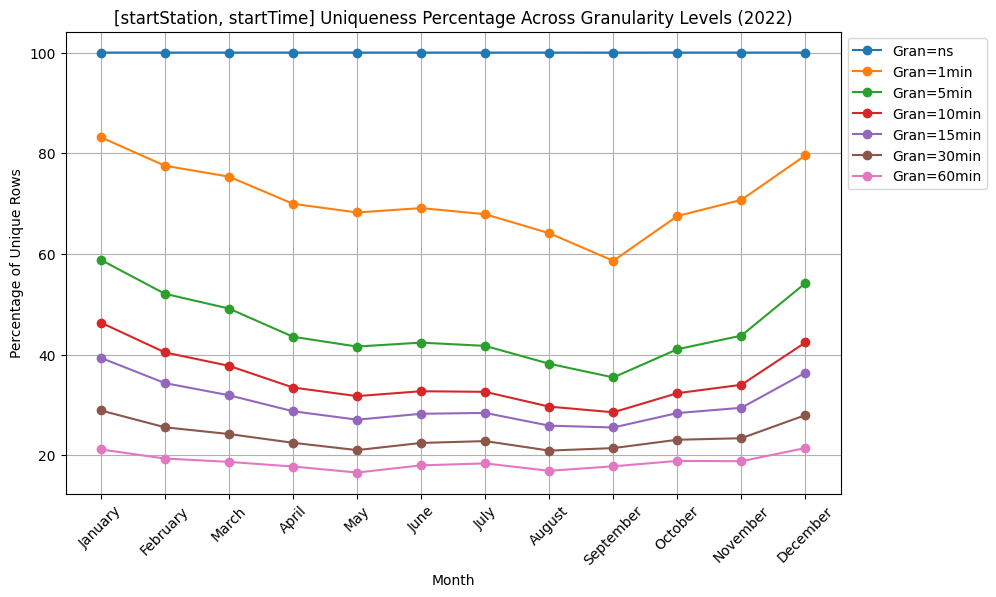

In [21]:
# Collect results for 2022
#
allResults = []

for monthIdx, csvFile in enumerate(csvFiles):
  df = load2022Month(csvFile)
  allResults.extend(RQ1(df, monthIdx))

df_results = pd.DataFrame(allResults)


# Plot
#
plt.figure(figsize=(10, 6))
for gran in df_results["Granularity"].unique():
    subset = df_results[df_results["Granularity"] == gran]
    plt.plot(subset["Month"], subset["Percent Unique"], marker='o', label=f'Gran={gran}')

plt.xlabel("Month")
plt.ylabel("Percentage of Unique Rows")
plt.title("[startStation, startTime] Uniqueness Percentage Across Granularity Levels (2022)")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()